У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Machine_Learning/datasets/module_02_05/train.csv.zip')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head(10)

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



### Графіки середніх значень із довірчими інтервалами для вибраних айтемів

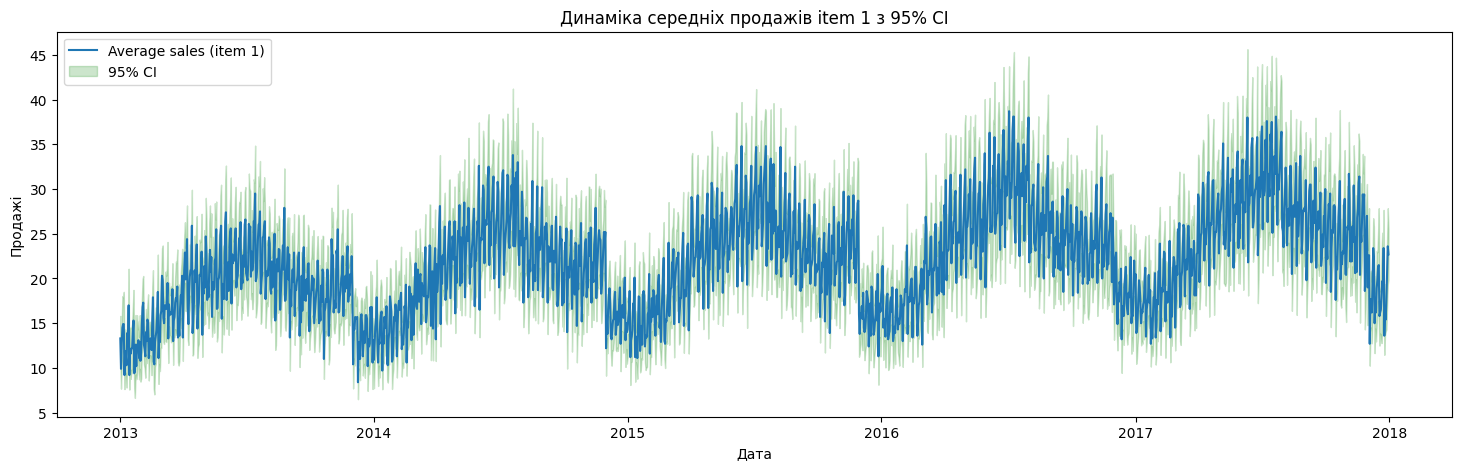

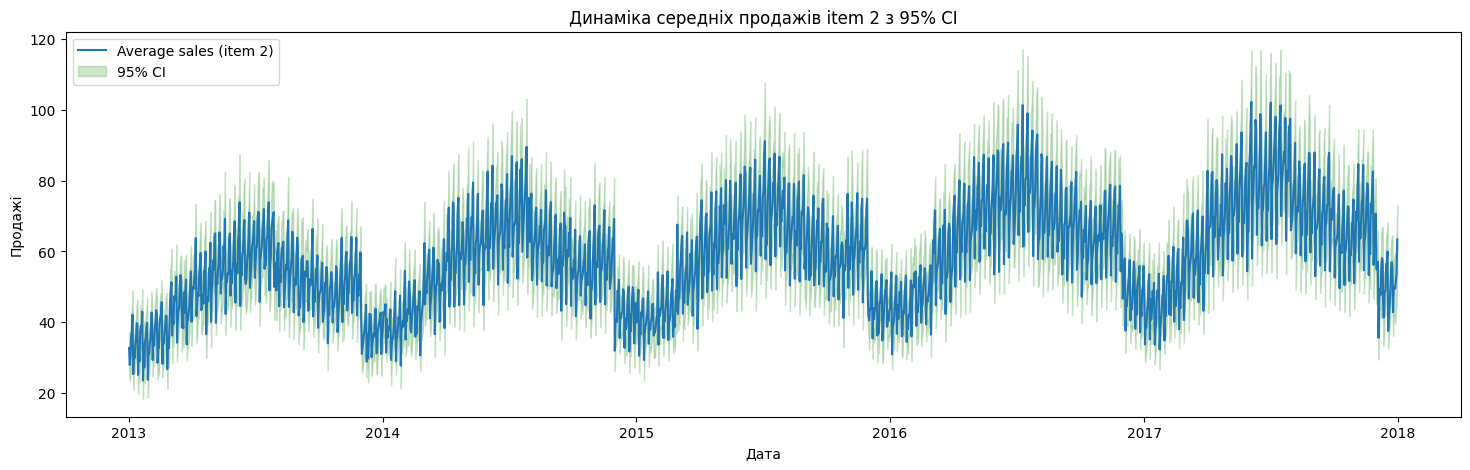

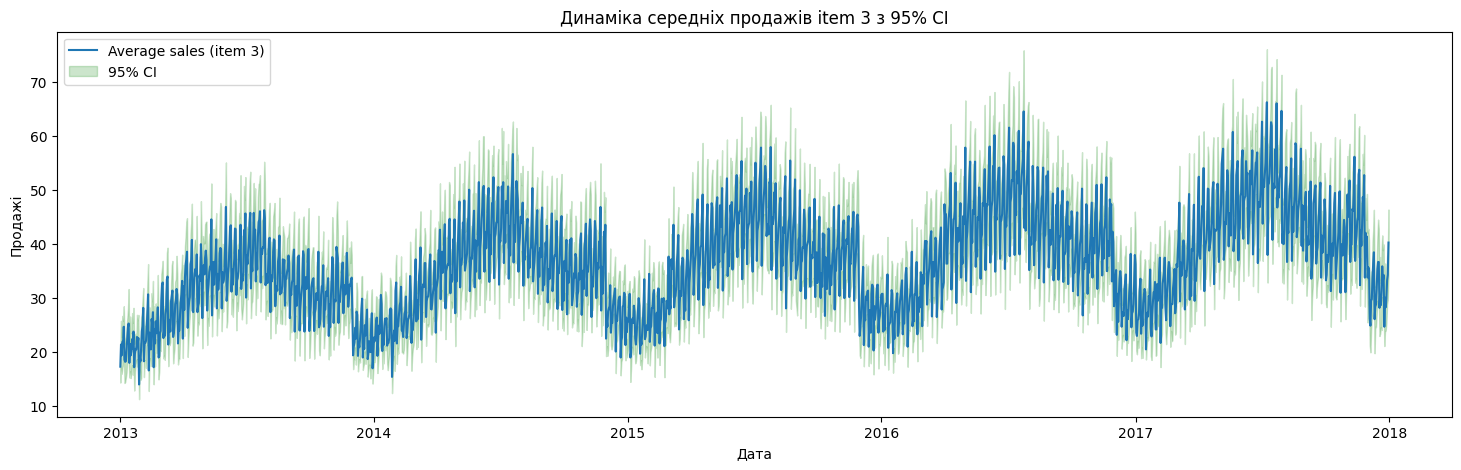

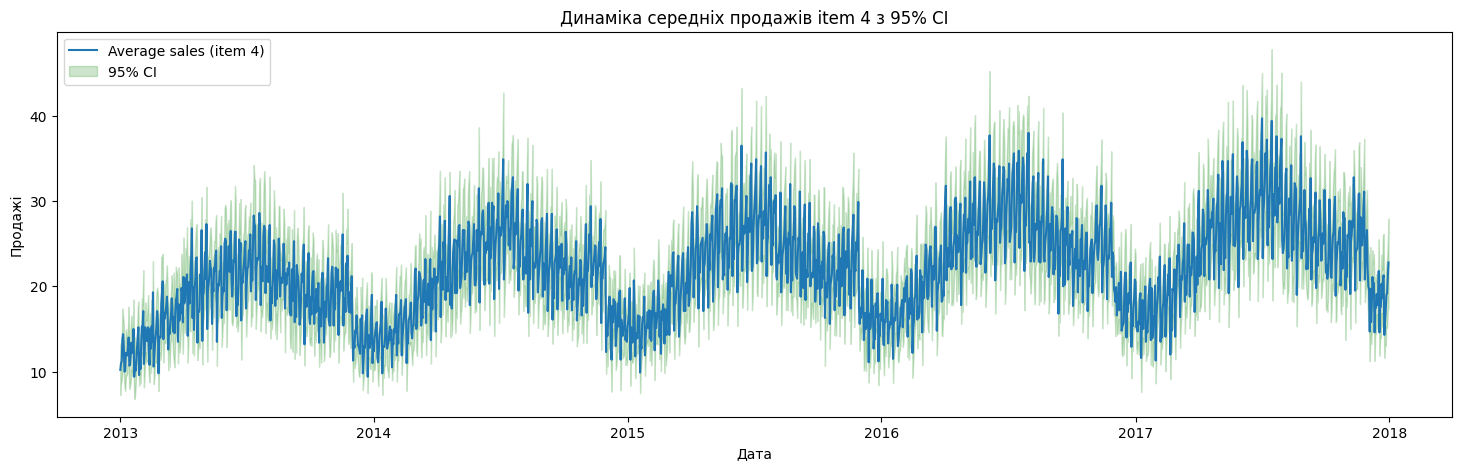

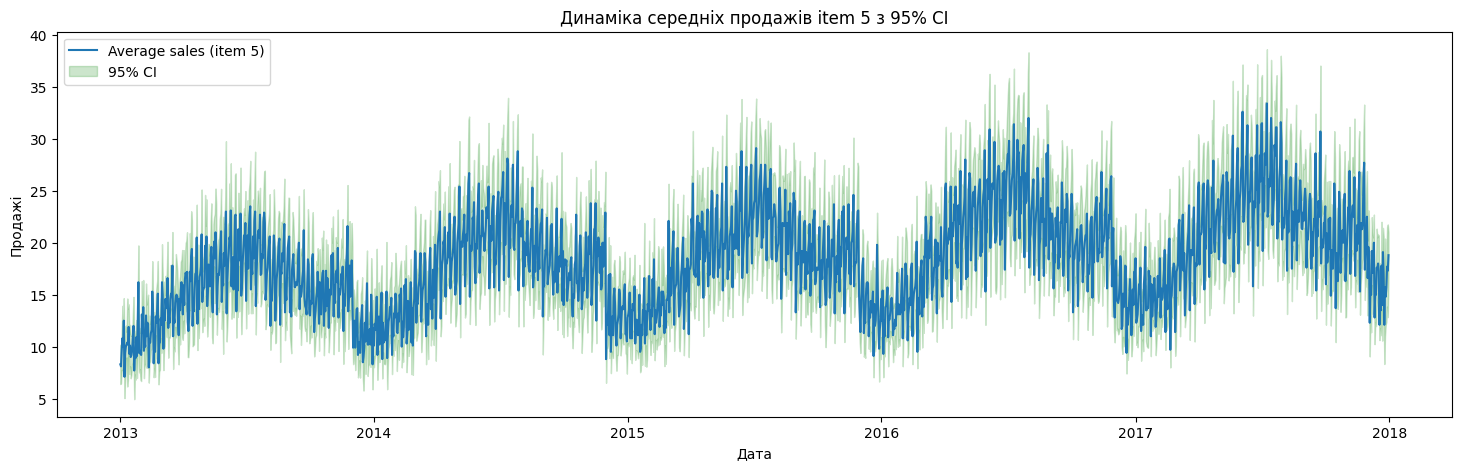

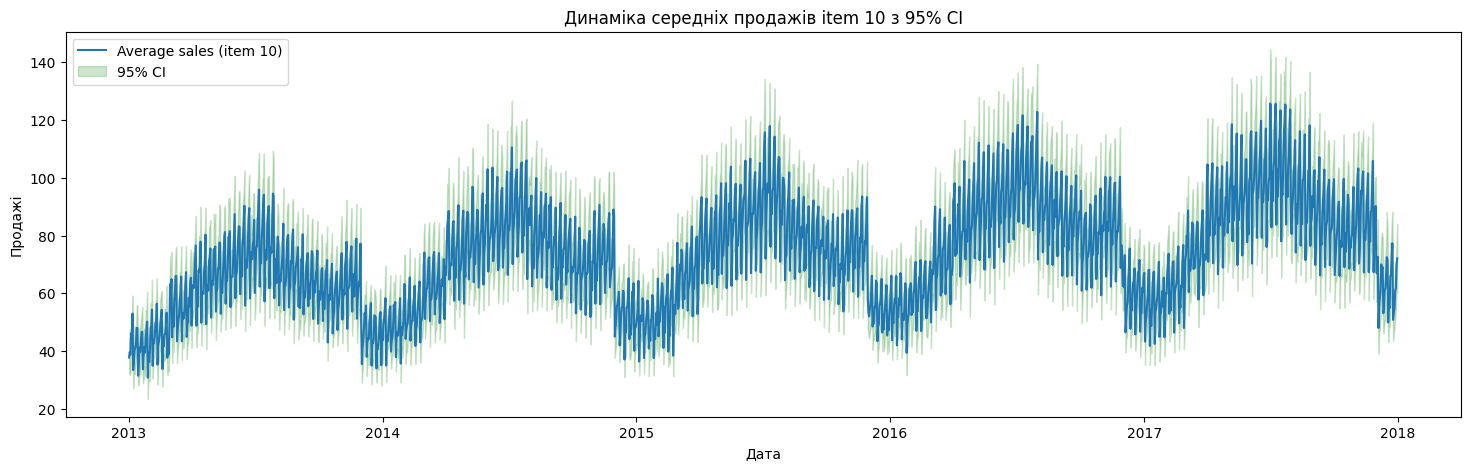

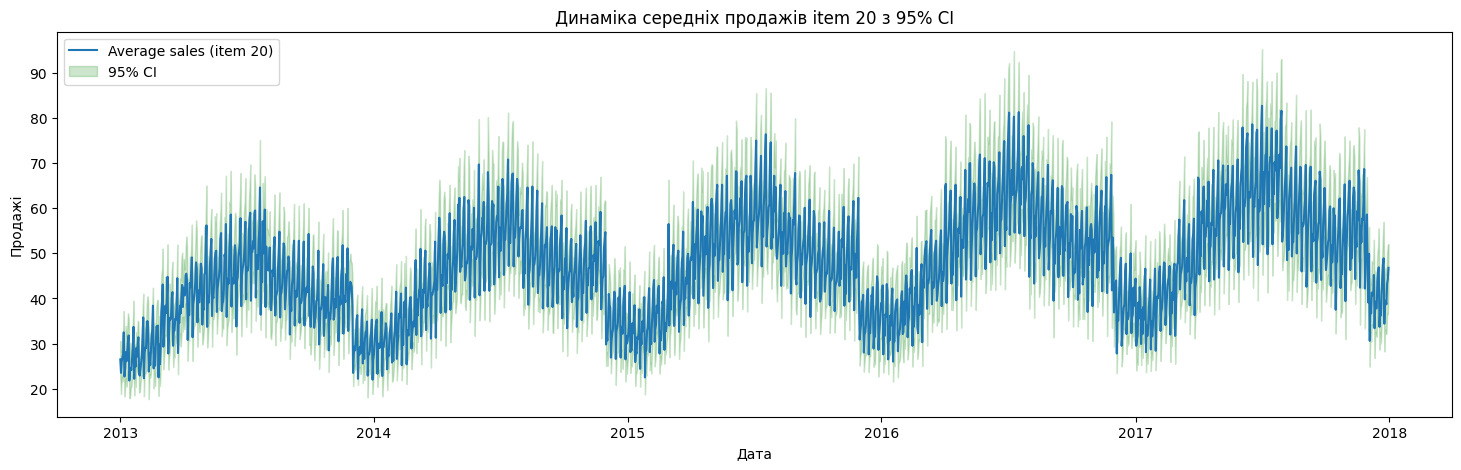

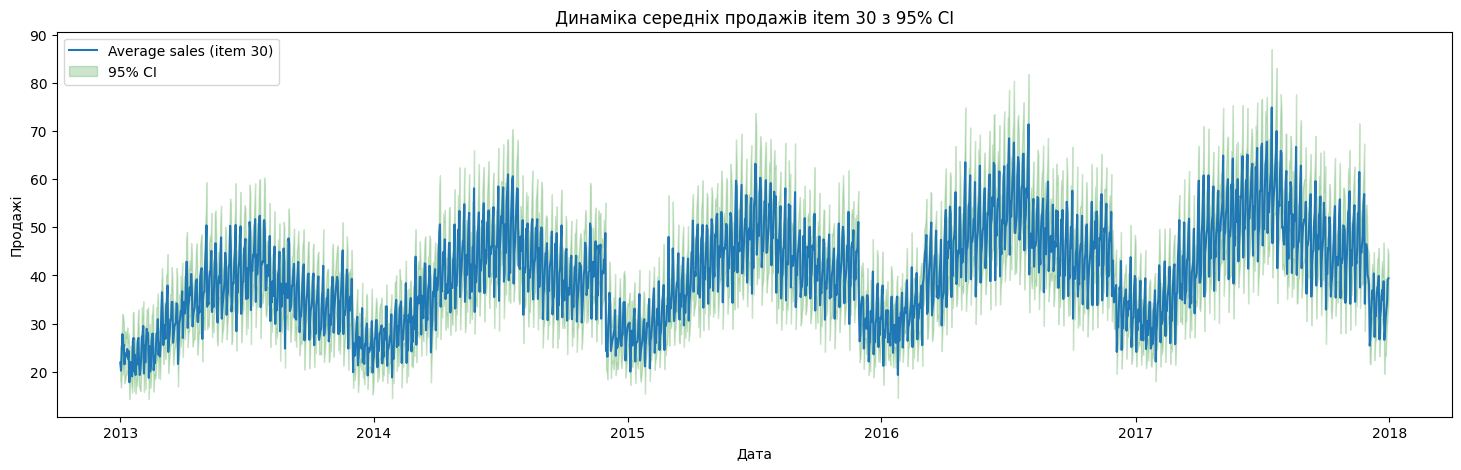

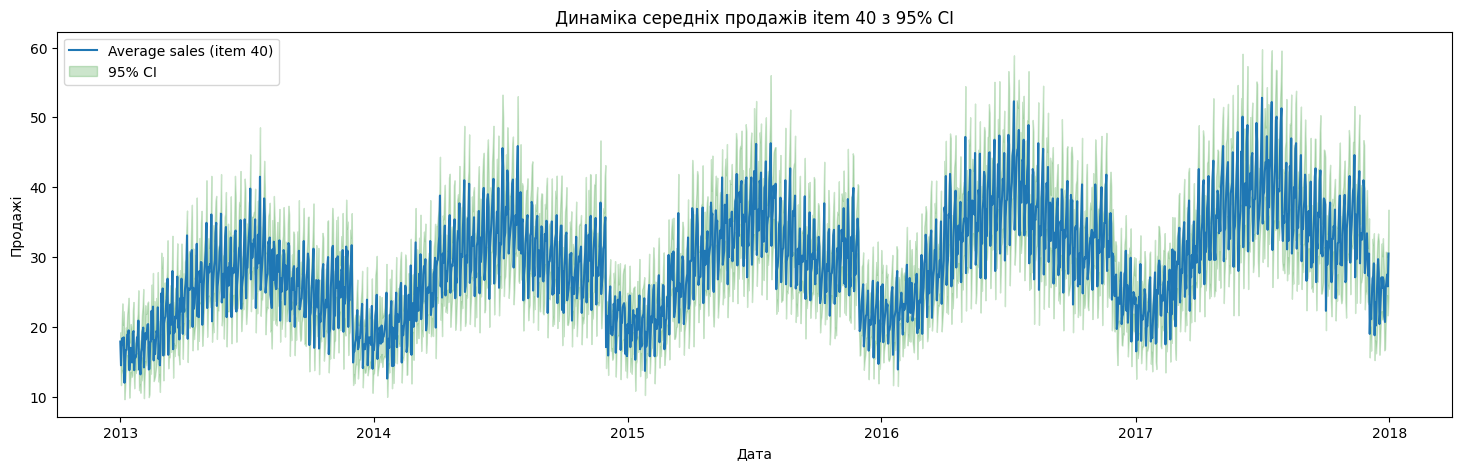

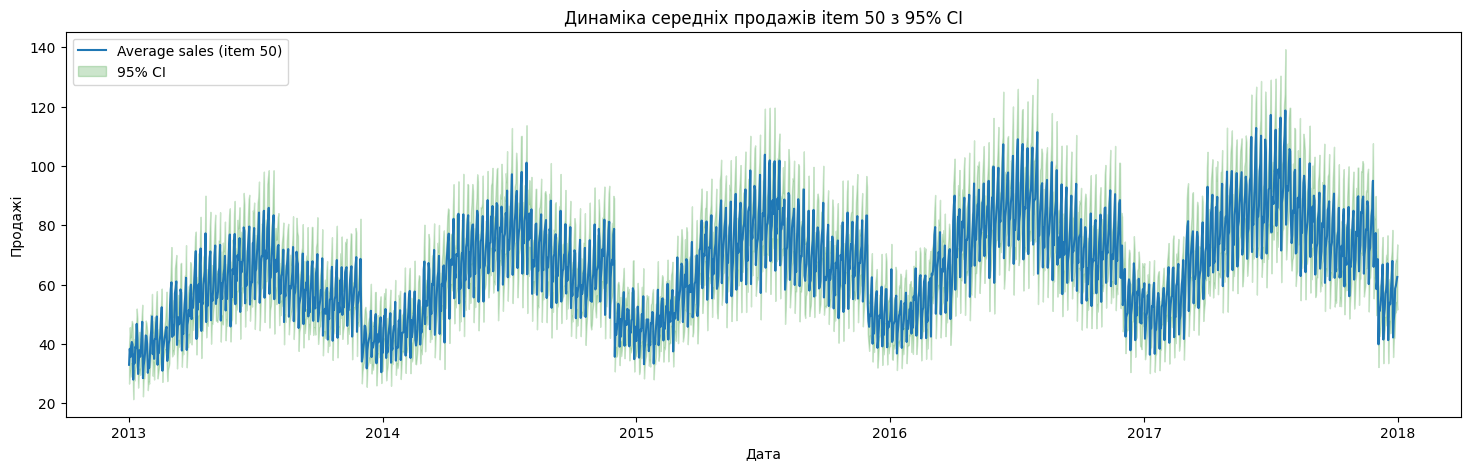

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def items_trend(data, items, ci=0.95):
    z_score = 1.96 if ci == 0.95 else None

    for item_id in items:
        df_item = data[data["item"] == item_id]

        grouping_key = df_item.index if isinstance(df_item.index, pd.DatetimeIndex) else df_item["date"]

        avg_sales = df_item.groupby(grouping_key)["sales"].agg(["mean", "std", "count"])
        avg_sales["ci"] = z_score * avg_sales["std"] / np.sqrt(avg_sales["count"])

        plt.figure(figsize=(18,5))
        plt.plot(avg_sales.index, avg_sales["mean"], label=f"Average sales (item {item_id})")
        plt.fill_between(avg_sales.index,
                         avg_sales["mean"] - avg_sales["ci"],
                         avg_sales["mean"] + avg_sales["ci"],
                         alpha=0.2, label="95% CI",
                         color="green")
        plt.title(f"Динаміка середніх продажів item {item_id} з {int(ci*100)}% CI")
        plt.xlabel("Дата")
        plt.ylabel("Продажі")
        plt.legend()
        plt.show()

items_trend(data, [1, 2, 3, 4, 5, 10, 20, 30, 40, 50])


### Графіки середніх значень без довірчих інтервалів для всіх 50 айтемів

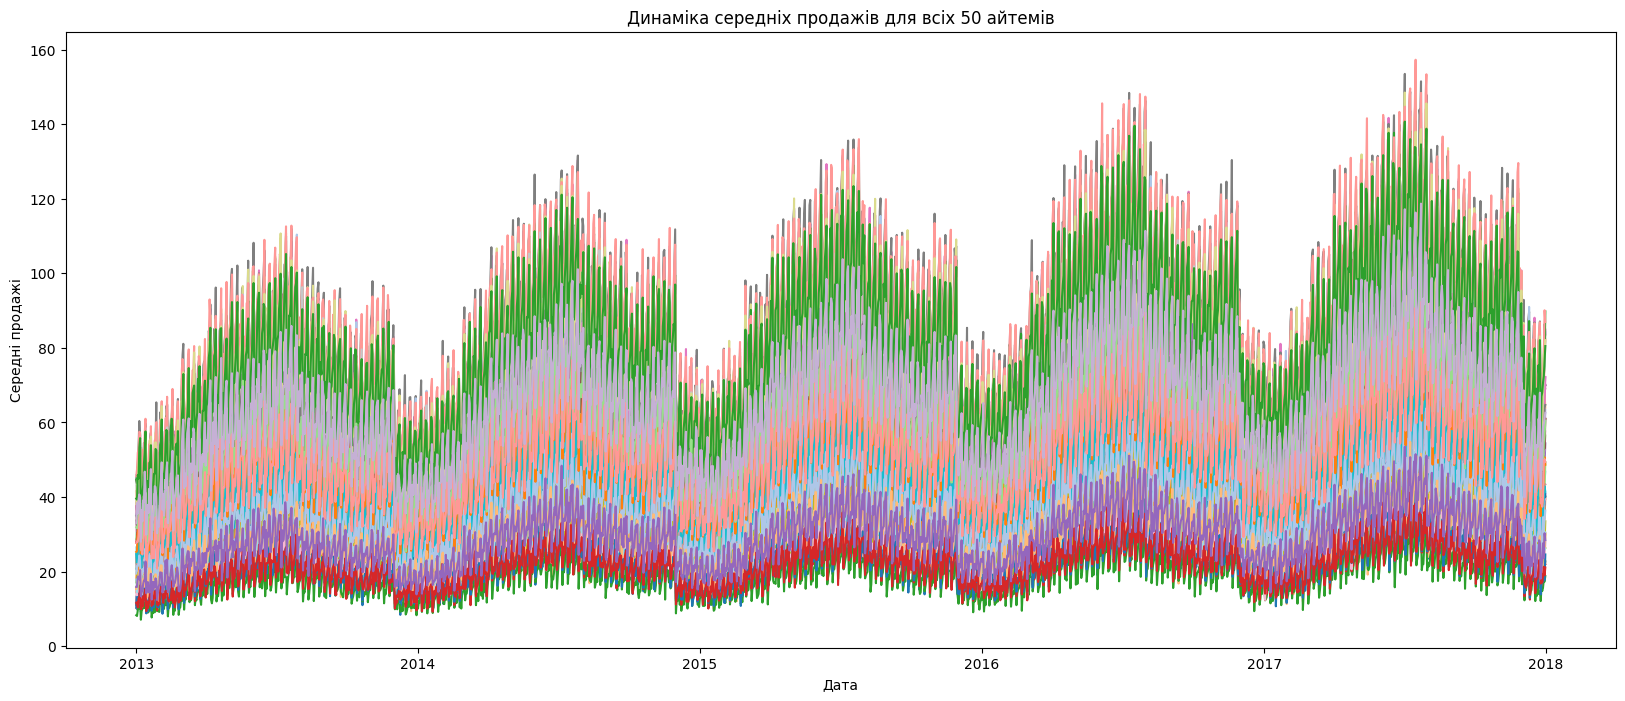

In [ ]:
avg_sales_all = (
    data
    .groupby([data.index, "item"])["sales"]
    .mean()
    .reset_index()
    .rename(columns={"index": "date"})
)

plt.figure(figsize=(20,8))
sns.lineplot(data=avg_sales_all, x="date", y="sales", hue="item", palette="tab20", legend=False)
plt.title("Динаміка середніх продажів для всіх 50 айтемів")
plt.xlabel("Дата")
plt.ylabel("Середні продажі")
plt.show()


### Висновок:  
Різні айтеми мають різний обсяг продажів, але для всіх спостерігається сезонність протягом року: зростаючий тренд до середини року і спадний тренд, починаючи з середини і до кінця року. Таким чином пік продажів припадає на середину року, а найнижчий рівень продажів на початку і в кінці року

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

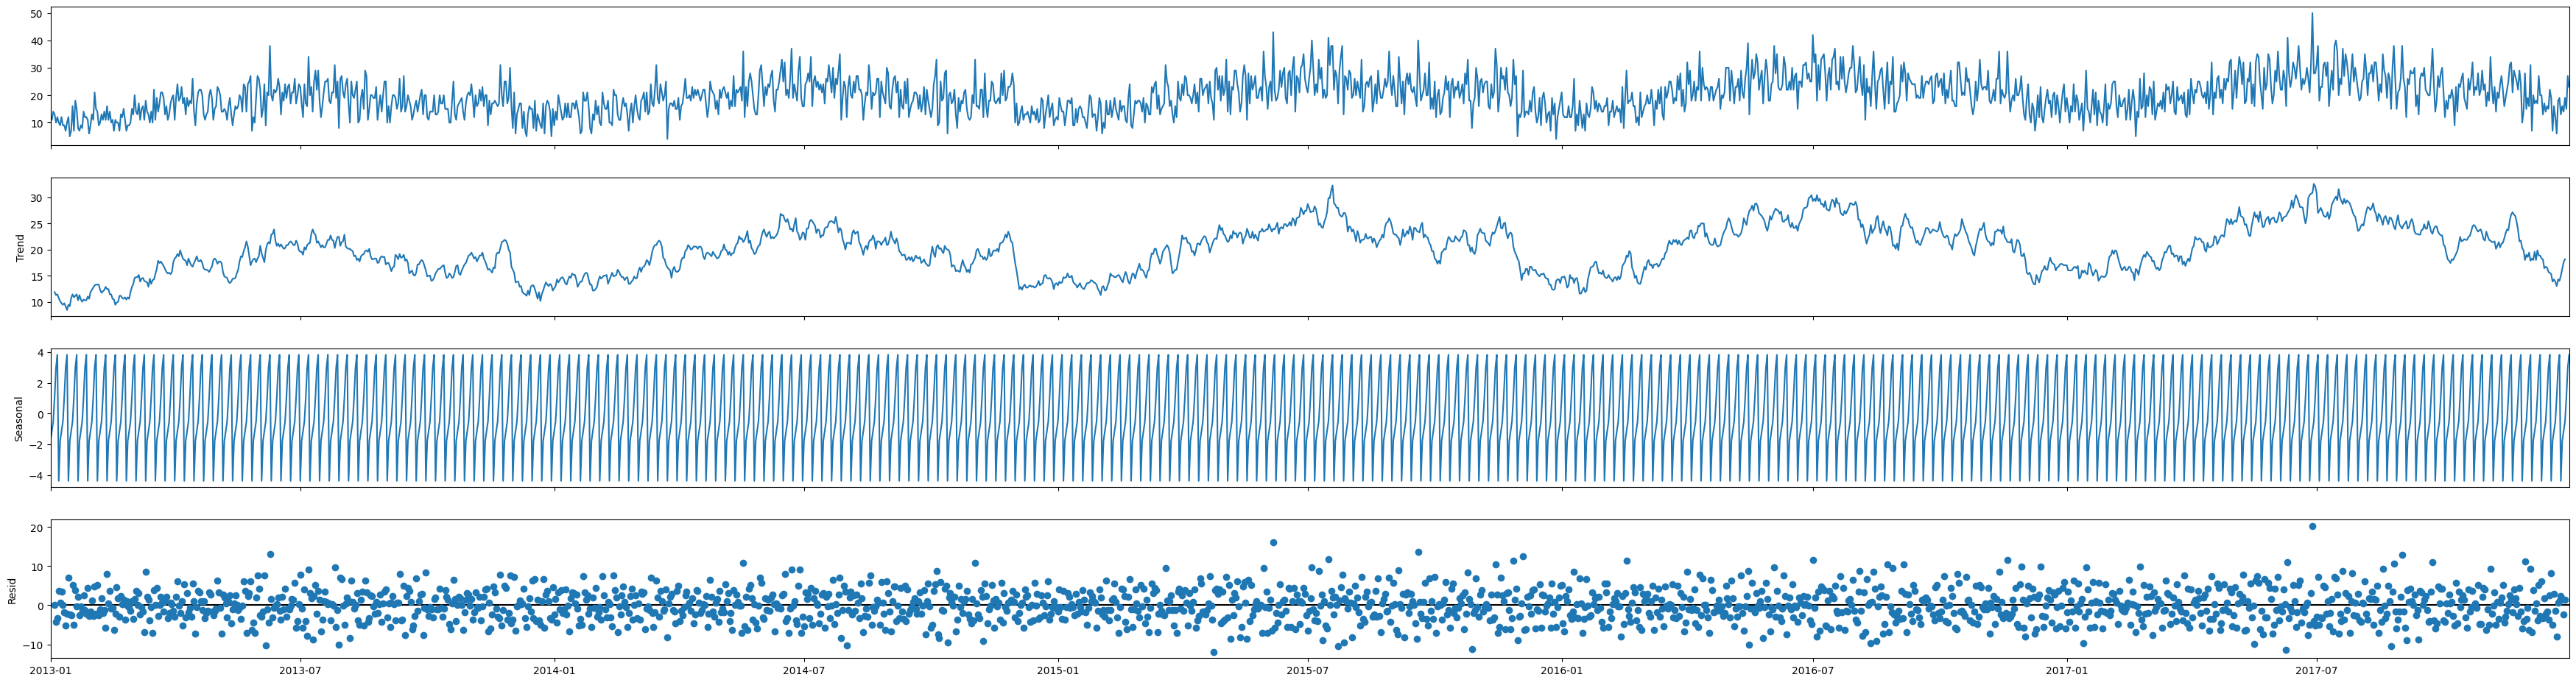

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

selected_data = data[(data["item"] == 1) & (data["store"] == 1)][["sales"]]
decomposition = seasonal_decompose(selected_data, model='additive')
fig = decomposition.plot()
fig.set_size_inches(40, 10)
plt.show()

Значення residuals розташовані симетрично навколо нуля, але мають великий розкид в даних. У residuals не спостерігається якийсь паттерн

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [ ]:
from darts import TimeSeries
series = TimeSeries.from_dataframe(selected_data, value_cols="sales")
series

<TimeSeries (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

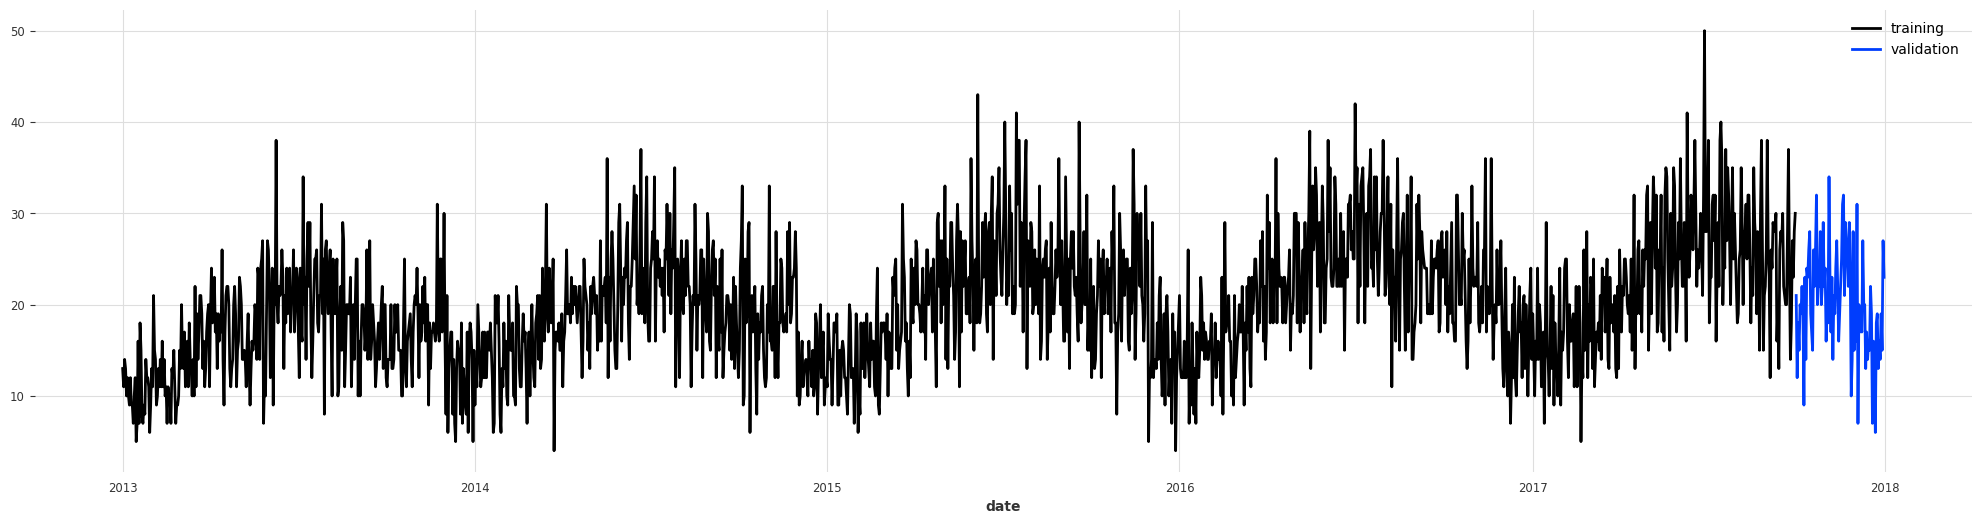

In [ ]:
train, val = series.split_before(pd.Timestamp("2017-10-01"))
plt.figure(figsize=(25,6))
train.plot(label="training")
val.plot(label="validation")
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

<Figure size 1000x600 with 0 Axes>

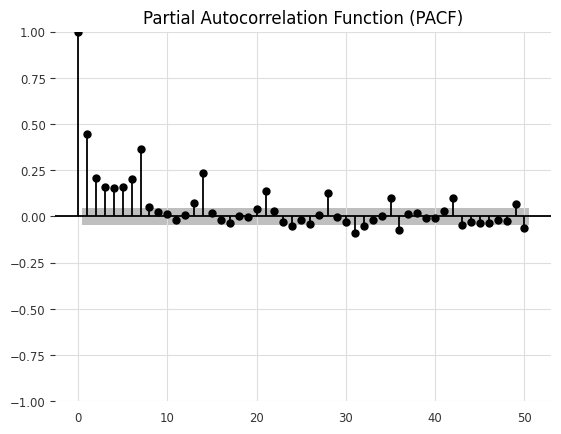

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
values = series.values()
plt.figure(figsize=(10, 6))
plot_pacf(values, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

За межі довірчого інтервалу виходять лаги: з 1 по 7, 13, 14, 21, 28, 31, 35, 36, 42, 49, 50. Найбільше - 1, 7 і 14.  


7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [ ]:
from darts.utils.statistics import check_seasonality
for m in range(2, 50):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05, max_lag=max(m, 50))
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

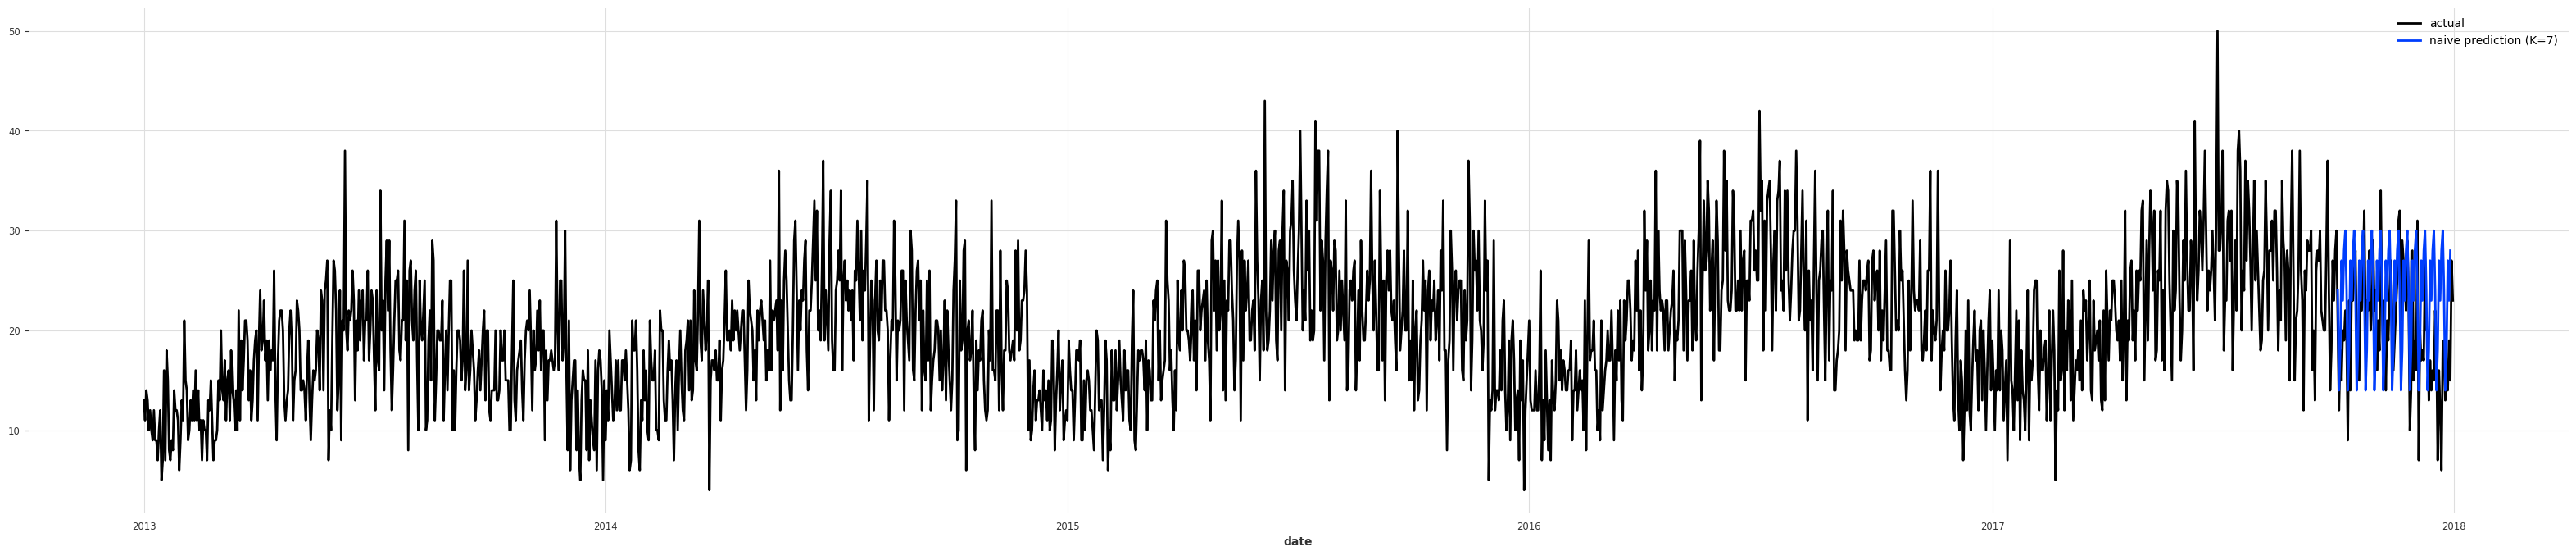

In [ ]:
from darts.models import NaiveSeasonal
from darts.models import NaiveDrift

seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(90)
plt.figure(figsize=(40, 8))
series.plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=7)")
plt.show()

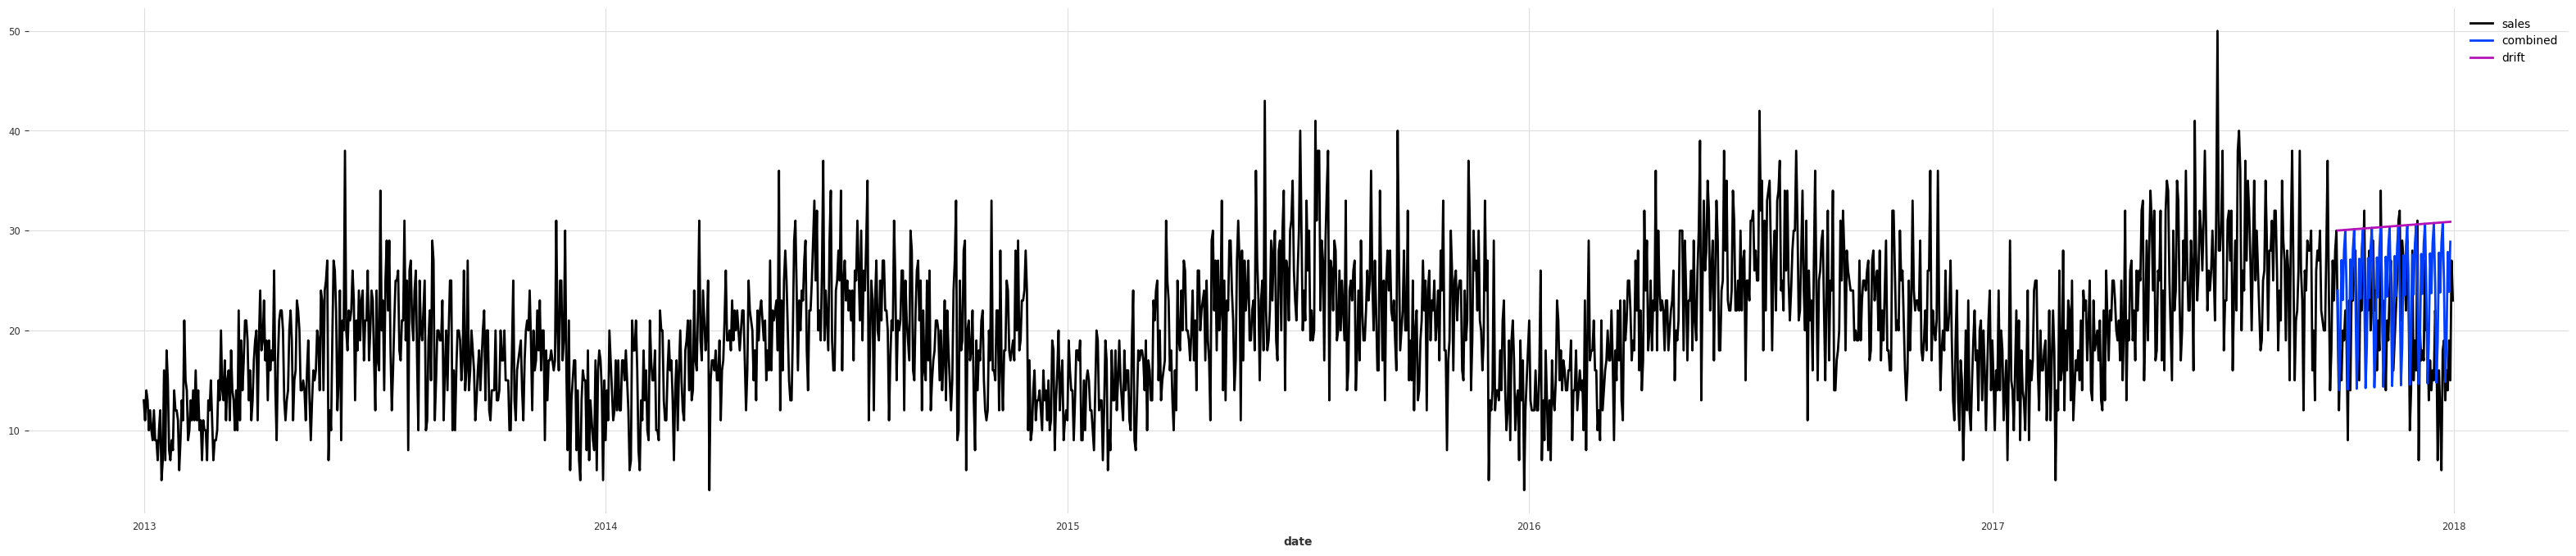

In [ ]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(90)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
plt.figure(figsize=(40, 8))
series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")
plt.show()

Отримані моделі не є точними, прогнози досить слабо попадають у фактичні дані. Потенційно можна вибрати іншу сезонність (оскільки на попередніх етапах аналізу було отримано декілька значень), але це не покращує якість моделі.  
Для NaiveDrift можна додавати ваги для drift_forecast i seasonal_forecast, але також кращої моделі отримати не вдалося

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [ ]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 40.54%.


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [ ]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  # Feature Extraction
  # df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["month"] = df['date'].dt.month
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train.to_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.to_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Побудова моделі XGBoost
model = XGBModel(
    lags=50,  # Використання останніх 50 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(90)
pred.values()

array([[0.5206793 ],
       [0.3475207 ],
       [0.3930026 ],
       [0.40803683],
       [0.3726808 ],
       [0.5518563 ],
       [0.5640391 ],
       [0.4762293 ],
       [0.24725091],
       [0.35325578],
       [0.35560206],
       [0.42897105],
       [0.49684882],
       [0.55534285],
       [0.48668712],
       [0.290992  ],
       [0.34556863],
       [0.39045718],
       [0.43723908],
       [0.4930111 ],
       [0.5422284 ],
       [0.53263736],
       [0.27094284],
       [0.34977657],
       [0.37973103],
       [0.42449194],
       [0.49923885],
       [0.5194854 ],
       [0.49570486],
       [0.27049756],
       [0.3513515 ],
       [0.3604675 ],
       [0.39368412],
       [0.5243732 ],
       [0.5423745 ],
       [0.48448503],
       [0.22115119],
       [0.35815755],
       [0.384523  ],
       [0.35614297],
       [0.49635375],
       [0.50358486],
       [0.51803654],
       [0.2592581 ],
       [0.33525905],
       [0.371374  ],
       [0.3566958 ],
       [0.501

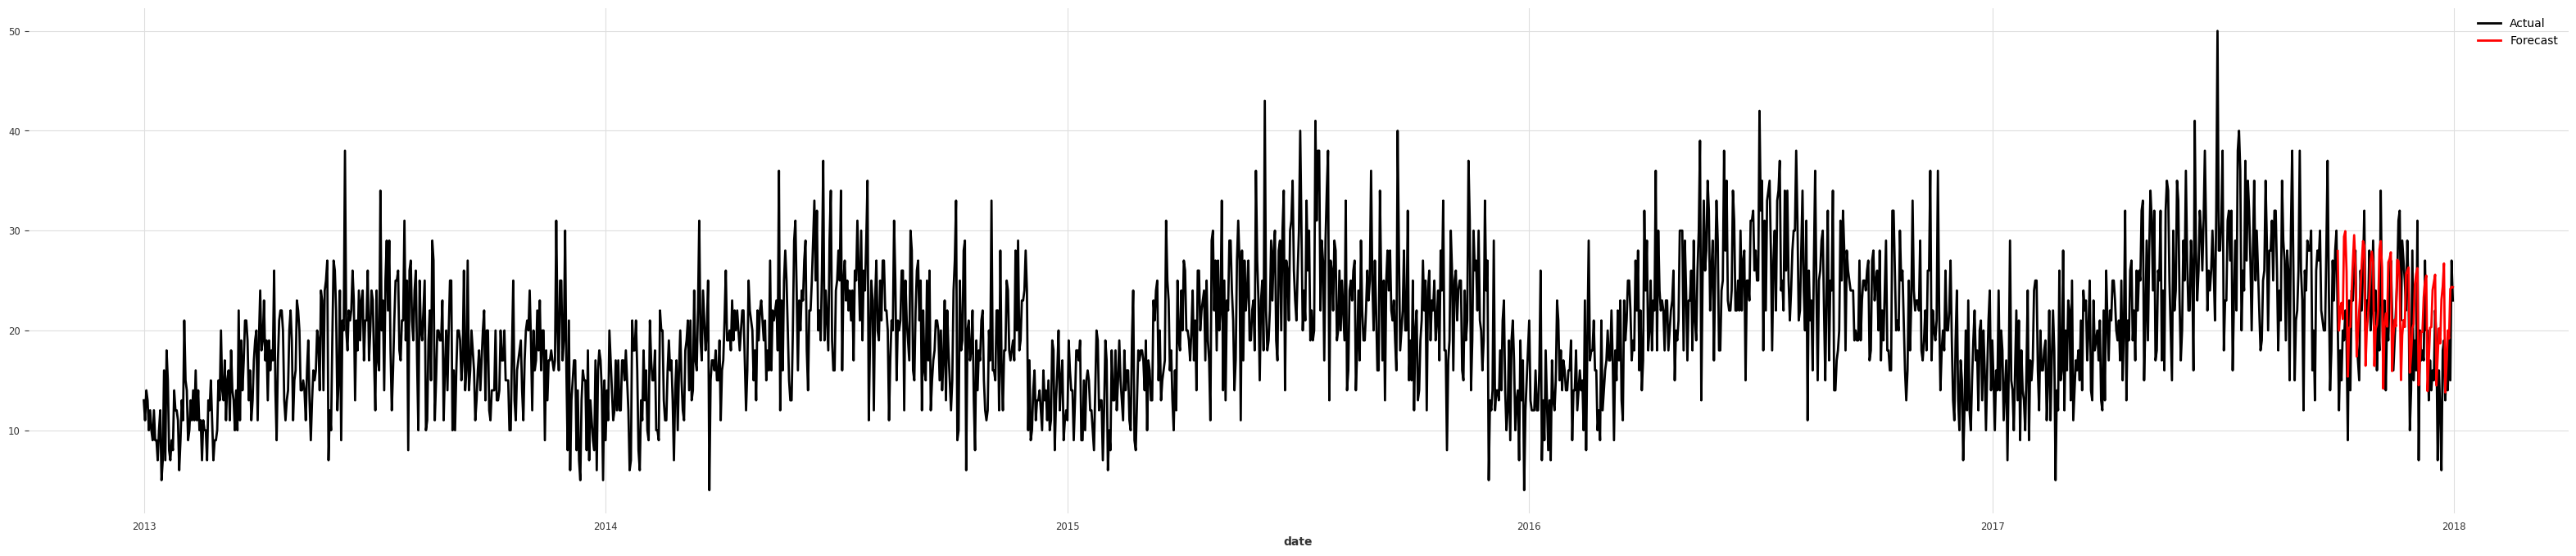

In [ ]:
scaler.inverse_transform(pred)
forecast = scaler.inverse_transform(model.predict(len(val)))
plt.figure(figsize=(40, 8))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [ ]:
def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

eval_forecast(model, val, forecast)

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...) obtains MAPE: 29.80%


np.float64(29.80498953295422)

### Висновок:  
модель має все ще велику помилку - 29.8%, але це краще, ніж в наївних моделей. Також з графіку видно, що XGBModel дещо краще прогнозує тренд, ніж наївні моделі. Проте, це все ще велика помилка і прогноз треба покращувати

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

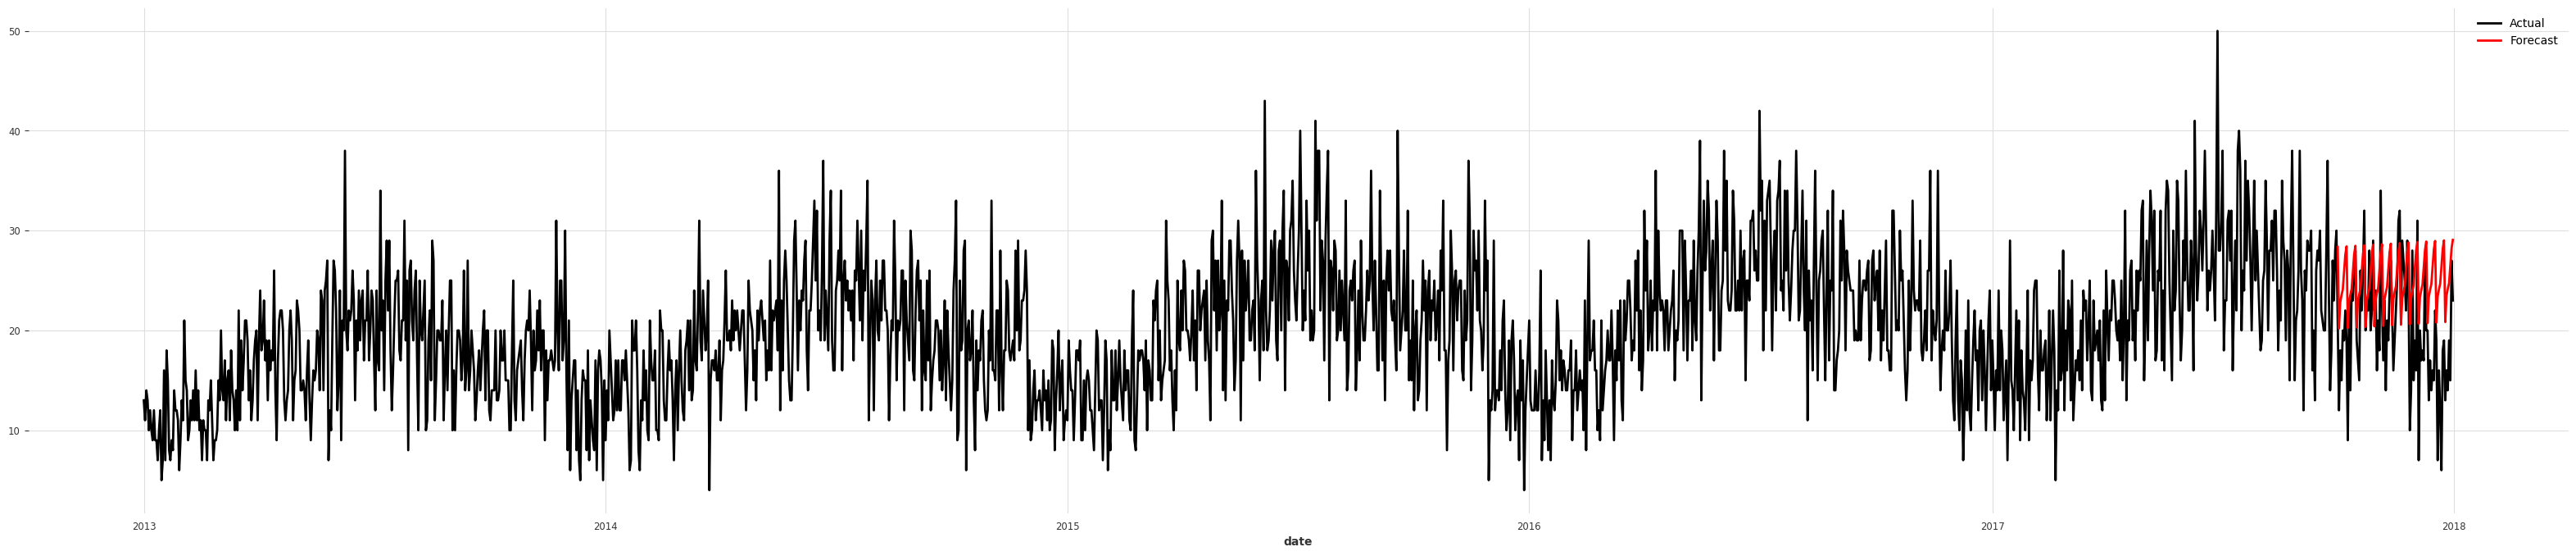

model ExponentialSmoothing() obtains MAPE: 39.01%


In [ ]:
from darts.models import ExponentialSmoothing
def plot_results(series, forecast):
  # Візуалізація результатів
  plt.figure(figsize=(40,8))
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)

### Висновок:  
ExponentialSmoothing має гіршу якість, ніж XGBModel: MAPE=39%, також із графіка видно, що вона погано прогнозує тренд

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


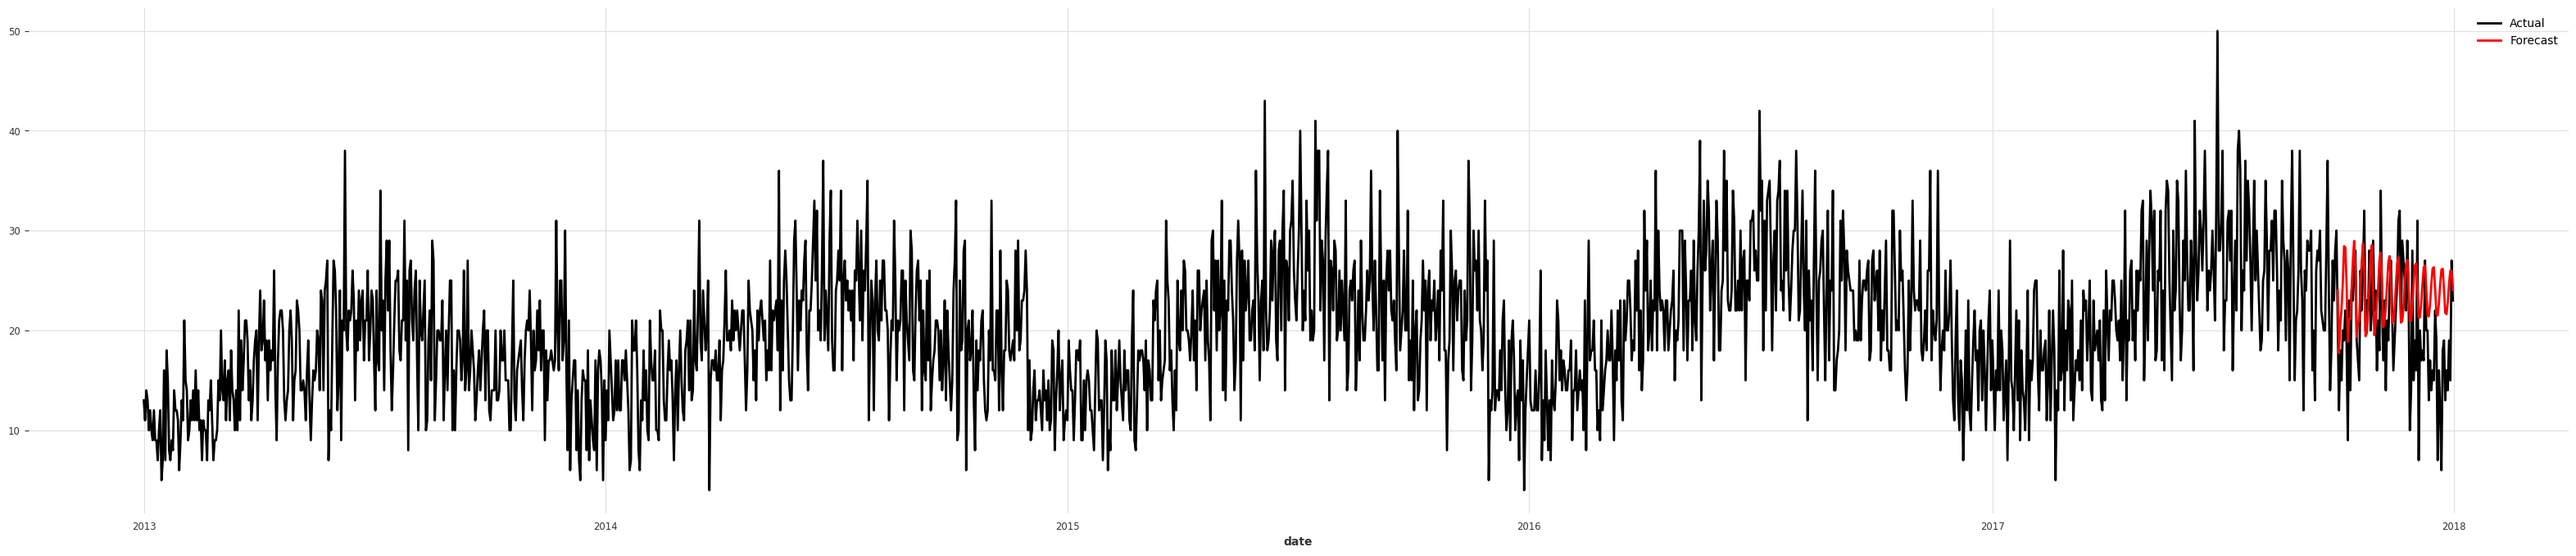

model ARIMA(p=35, q=1) obtains MAPE: 36.11%


In [ ]:
from darts.models import ARIMA

# Побудова та тренування моделі ARIMA
model = ARIMA(p=35, d=1, q=1)
fit_and_plot(model, series, train, val)

### Висновок:  
ARIMA також має низьку якість при різних значеннях параметру p. Найкращий результат, який вдалося досягти - 36.1%. З графіку видно, що модель погано прогнозує тренд

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

AutoARIMA(add_encoders=None, quantiles=None, random_state=None, start_p=1, max_p=100, start_q=1)

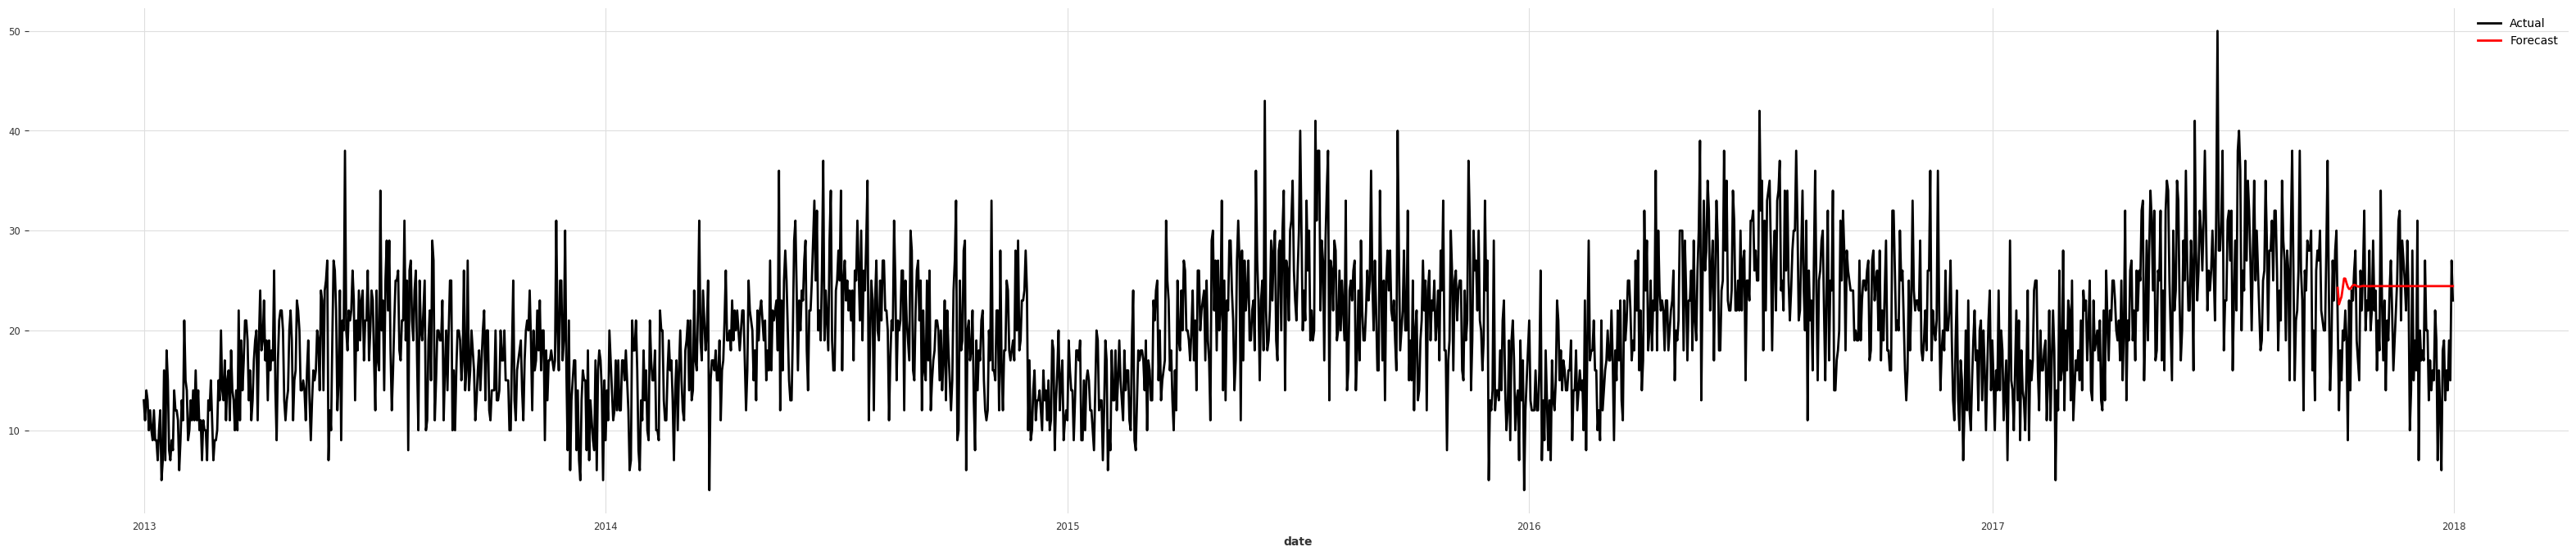

model AutoARIMA(start_p=1, max_p=100, start_q=1) obtains MAPE: 40.29%


np.float64(40.294072271660795)

In [ ]:
from darts.models import AutoARIMA
# Побудова та тренування моделі AutoArima
model = AutoARIMA(start_p=1, max_p=100, start_q=1) # спробуйте стартувати з інших значень і перегляньте, що виходить
model.fit(train)

display(model)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
plot_results(series, forecast)

eval_forecast(model, val, forecast)

### Висновок:  
Якість моделі не покращилася, а навіть погіршилась: MAPE=40.3% порівняно з 36.1% у минулій моделі

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5rm3o59/ro3ch3d_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5rm3o59/kvhdhbcs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81884', 'data', 'file=/tmp/tmpe5rm3o59/ro3ch3d_.json', 'init=/tmp/tmpe5rm3o59/kvhdhbcs.json', 'output', 'file=/tmp/tmpe5rm3o59/prophet_model6dlyv4mh/prophet_model-20250816072600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:26:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:26:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


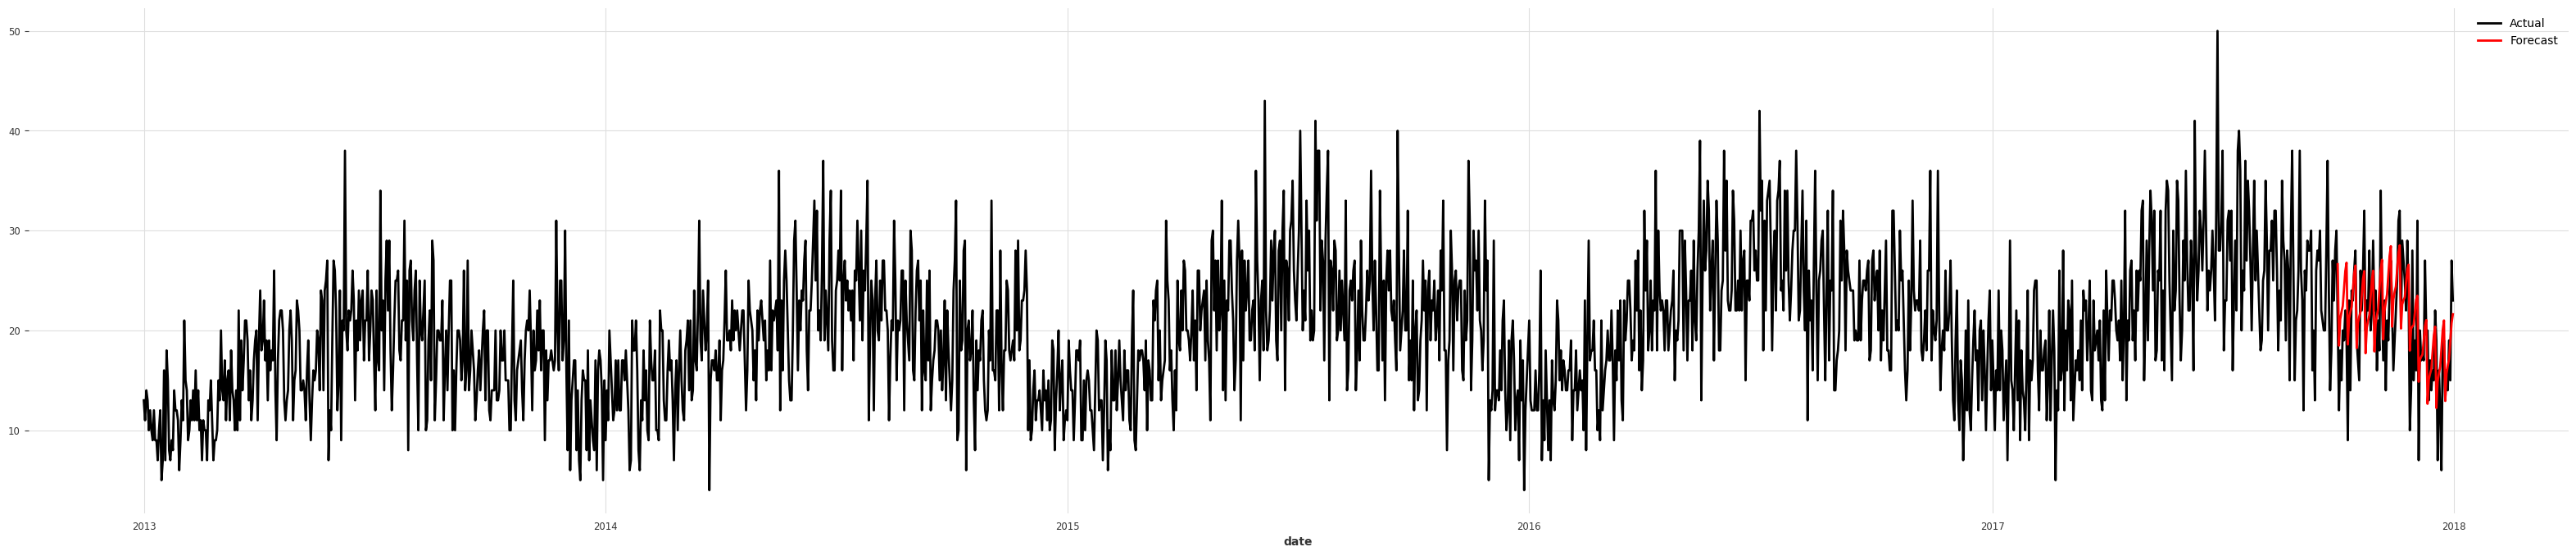

In [ ]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
plt.figure(figsize=(40,8))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [ ]:
eval_forecast(model, val, forecast)

model Prophet() obtains MAPE: 23.80%


np.float64(23.80480380321674)

### Висновок:  
помилка все ще висока, але наразі ця модель показала кращий результат - MAPE=23.8%. Також модель непогано прогнозує загальний напрям тренду, але слабо відтворює амплітуду даних

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.023     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

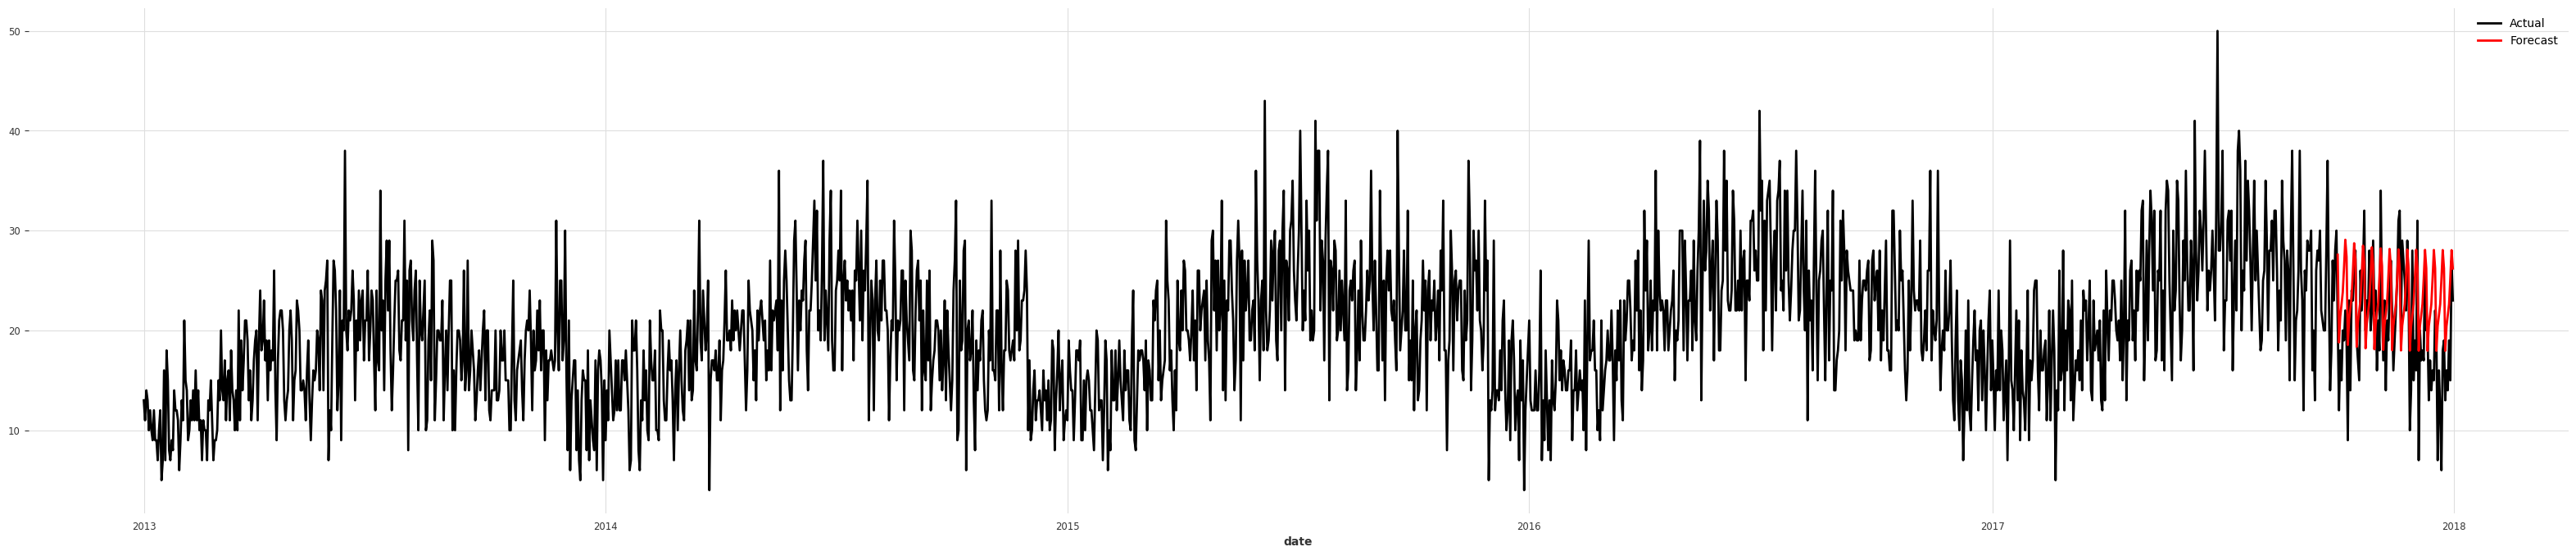

In [ ]:
from darts.models import RNNModel

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=28, training_length=28, n_epochs=300)
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
plt.figure(figsize=(40,8))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [ ]:
eval_forecast(model, val, forecast)

model RNNModel(model=LSTM, training_length=28, input_chunk_length=28, n_epochs=300) obtains MAPE: 33.57%


np.float64(33.5733834748399)

### Висновок:  
Модель показує гіршу якість ніж попередня: має вищий MAPE і гірше відтворює тренд

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [ ]:
# наша найкраща модель

model = Prophet(weekly_seasonality=True)
model.fit(train)
forecast = model.predict(len(val))
eval_forecast(model, val, forecast);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5rm3o59/uk1_0jmf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5rm3o59/jh9rgmp7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37580', 'data', 'file=/tmp/tmpe5rm3o59/uk1_0jmf.json', 'init=/tmp/tmpe5rm3o59/jh9rgmp7.json', 'output', 'file=/tmp/tmpe5rm3o59/prophet_model5mtmkubx/prophet_model-20250816080024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:00:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


model Prophet(weekly_seasonality=True) obtains MAPE: 23.80%


historical forecasts:   0%|          | 0/336 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5rm3o59/r_b88ab4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5rm3o59/168rx3lo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8297', 'data', 'file=/tmp/tmpe5rm3o59/r_b88ab4.json', 'init=/tmp/tmpe5rm3o59/168rx3lo.json', 'output', 'file=/tmp/tmpe5rm3o59/prophet_model9fruccyg/prophet_model-20250816081531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   0%|          | 1/336 [00:00<02:38,  2.11it/s]INFO:prophet:

MAPE = 20.37%


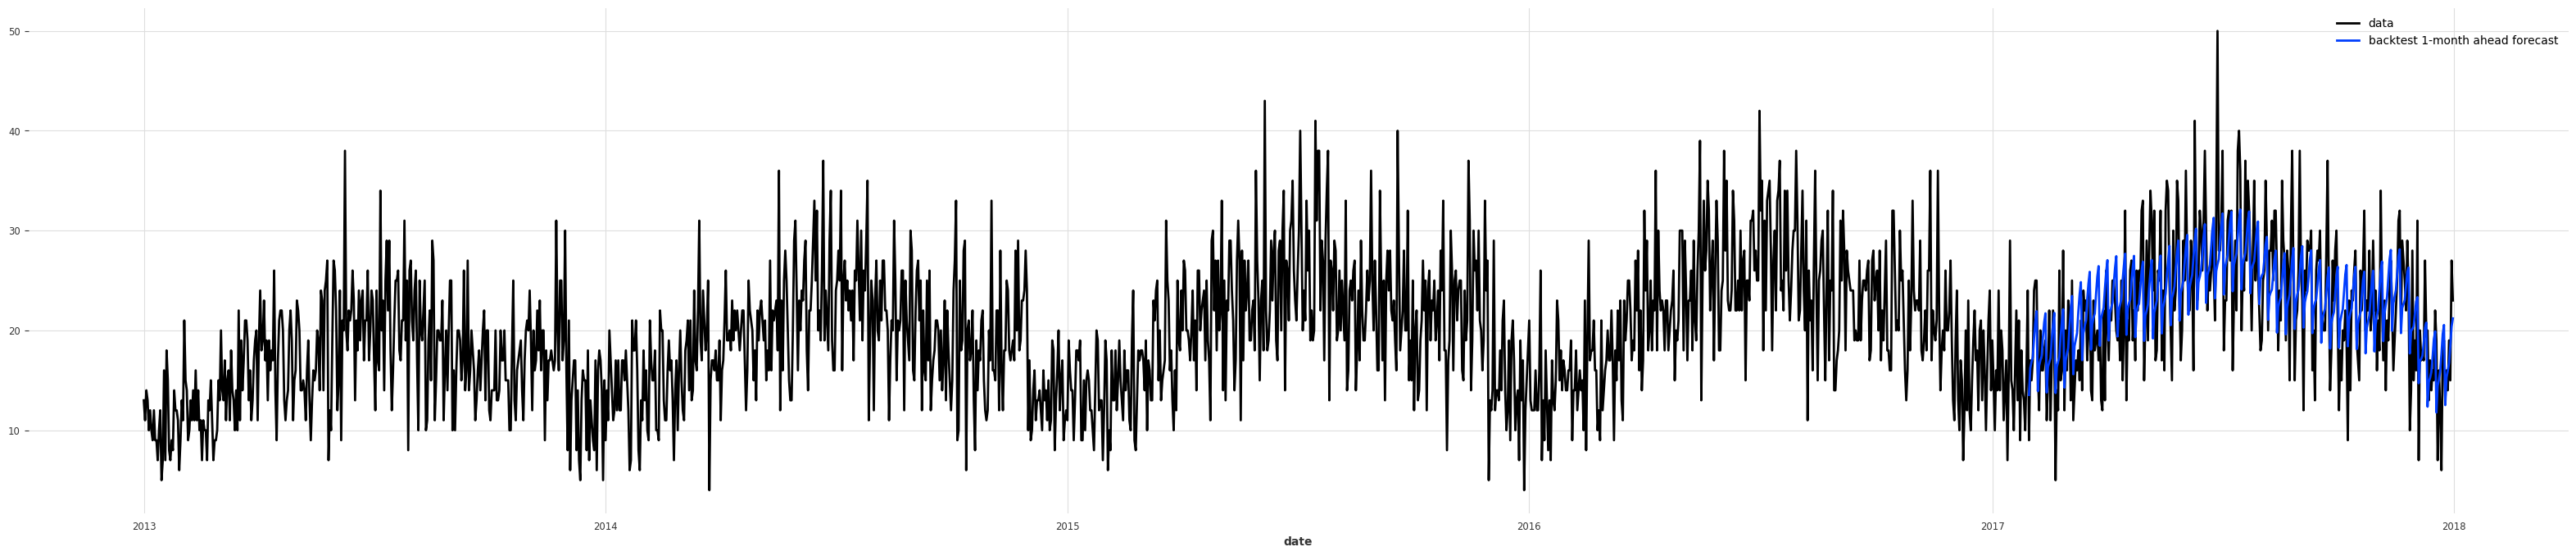

In [ ]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp(series.time_index[-365]),
    "forecast_horizon": 30,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)
plt.figure(figsize=(40,8))
series.plot(label="data")
historical_fcast.plot(label="backtest 1-month ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

In [ ]:
average_error = model.backtest(
    metric=mape,
    reduction=np.mean,  # this is actually the default
    **hfc_params
)

print(f"Average error (MAPE) over all historical forecasts: {average_error:.2f}")

historical forecasts:   0%|          | 0/336 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5rm3o59/qzg79076.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5rm3o59/fleapvl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10176', 'data', 'file=/tmp/tmpe5rm3o59/qzg79076.json', 'init=/tmp/tmpe5rm3o59/fleapvl3.json', 'output', 'file=/tmp/tmpe5rm3o59/prophet_modeldy6776ee/prophet_model-20250816083921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   0%|          | 1/336 [00:00<01:39,  3.35it/s]INFO:prophet

Average error (MAPE) over all historical forecasts: 20.43


### Висновок:  
Помилка моделі 20.43%

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Використав би модель Prophet, тому що вона показала значно кращі результати, ніж інші моделі.
Оскільки маємо 50 айтемів у 10 магазинах, теоретично потрібно було б тренувати 500 моделей. Проте на прикладі одного айтема можна спробувати підхід, коли ми тренуємо айтем не в усіх 10 магазинах, а тільки один раз на усереднених даних. Тобто тренуємо айтем на усереднених даних з 10 магазинів, і тренуємо цей ж айтем 10 разів для окремих магазинів, і порівнюємо результати. Якщо усереднена модель показує не гірші результати, то немає потреби тренувати всі 500 моделей, а достатньо 50 - одна модель на один айтем. В іншому разі - потрібно тренувати 500 моделей  
